# Global Air Quality and Respiratory Health Outcomes
Dados Abrangentes de Várias Cidades sobre Métricas de Qualidade do Ar e Hospitalizações Respiratórias

## Sobre o Conjunto de Dados
Conjunto de Dados de Qualidade do Ar Global e Resultados em Saúde Respiratória
Este conjunto de dados fornece uma visão abrangente e multi-cidade das métricas diárias de qualidade do ar e das internações hospitalares relacionadas a problemas respiratórios correspondentes. Projetado para modelagem ambiental, análise de saúde pública e aplicações de aprendizado de máquina, ele permite uma exploração robusta da relação entre a poluição do ar urbano e os resultados em saúde.


- Link de referencia Kaggle: https://www.kaggle.com/datasets/tfisthis/global-air-quality-and-respiratory-health-outcomes

- Data conclusão: 21/06/2025

---
## 1 - Importação e Leitura da Base

Com base na leitura inicial sobre o dataset, possivelmente um problema de predição ou classificação, será feito para prever as cidades mais poluentes numa linha do tempo e quantidade de resultados ofensor na saúde.

Isso é uma hipotese, que pode mudar após analise da base.

In [23]:
#Bibliotecas para minupulação de dados
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Biblioteca para pre-processamento e implementação de ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Biblioteca para teste de simetria
from scipy.stats import normaltest

#Bibliotecas para transformação, montar pipeline de tratamento em colunas categoricas e balancear as numericas
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#Biblioteca para implementação de modelos de machine learning e avaliação
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [24]:
#Carrega dataset
df_original = pd.read_csv('air_quality_health_dataset.csv')

#Leitura inicial do dataset
df_original.head()

,city,date,aqi,pm2_5,pm10,no2,o3,temperature,humidity,hospital_admissions,population_density,hospital_capacity
0,Los Angeles,2020-01-01,65,34.0,52.7,2.2,38.5,33.5,33,5,Rural,1337
1,Beijing,2020-01-02,137,33.7,31.5,36.7,27.5,-1.6,32,4,Urban,1545
2,London,2020-01-03,266,43.0,59.6,30.4,57.3,36.4,25,10,Suburban,1539
3,Mexico City,2020-01-04,293,33.7,37.9,12.3,42.7,-1.0,67,10,Urban,552
4,Delhi,2020-01-05,493,50.3,34.8,31.2,35.6,33.5,72,9,Suburban,1631


### 1.1 - Exploração Basica

In [25]:
#Exibe informações gerais do dataset
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88489 entries, 0 to 88488
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   city                 88489 non-null  object 
 1   date                 88489 non-null  object 
 2   aqi                  88489 non-null  int64  
 3   pm2_5                88489 non-null  float64
 4   pm10                 88489 non-null  float64
 5   no2                  88489 non-null  float64
 6   o3                   88489 non-null  float64
 7   temperature          88489 non-null  float64
 8   humidity             88489 non-null  int64  
 9   hospital_admissions  88489 non-null  int64  
 10  population_density   88489 non-null  object 
 11  hospital_capacity    88489 non-null  int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 8.1+ MB


### Column Name	Description
- city:	Name of the city where data was recorded
- date:	Date of observation (YYYY-MM-DD)
- aqi:	Air Quality Index value
- pm2_5:	PM2.5 concentration (µg/m³)
- pm10:	PM10 concentration (µg/m³)
- no2:	Nitrogen dioxide concentration (ppb)
- o3:	Ozone concentration (ppb)
- temperature:	Daily average temperature (°C)
- humidity:	Daily average relative humidity (%)
- hospital_admissions:	Number of daily hospital admissions for respiratory issues
- population_density:	Urban, Suburban, or Rural classification
- hospital_capacity:	Number of beds available in local hospitals

In [26]:
#Verifica valores nulos
df_original.isnull().sum()

city                   0
date                   0
aqi                    0
pm2_5                  0
pm10                   0
no2                    0
o3                     0
temperature            0
humidity               0
hospital_admissions    0
population_density     0
hospital_capacity      0
dtype: int64

In [27]:
#Verifica valores duplicados
df_original.duplicated().sum()

np.int64(0)

In [28]:
#Estatisticas da base
df_original.describe()

,aqi,pm2_5,pm10,no2,o3,temperature,humidity,hospital_admissions,hospital_capacity
count,88489.000000,88489.000000,88489.000000,88489.000000,88489.000000,88489.000000,88489.000000,88489.000000,88489.000000
mean,249.370182,35.144951,50.118654,30.006211,39.978895,17.522962,56.950966,8.049385,1024.463165
std,144.479132,14.767994,19.796392,9.963139,12.007258,12.961024,21.629675,3.715458,561.978071
min,0.000000,0.000000,0.000000,0.000000,0.000000,-5.000000,20.000000,0.000000,50.000000
25%,124.000000,24.900000,36.600000,23.300000,31.900000,6.400000,38.000000,6.000000,539.000000
50%,249.000000,35.100000,50.000000,30.000000,40.000000,17.500000,57.000000,8.000000,1026.000000
75%,374.000000,45.200000,63.500000,36.700000,48.100000,28.700000,76.000000,10.000000,1511.000000
max,499.000000,109.900000,143.500000,71.400000,93.500000,40.000000,94.000000,25.000000,1999.000000


Possiveis outliers, visto que temos colunas com o Max, representando proximo ou maior que o dobro de 75% dos resultados da coluna. Verificação será feita posteriormente neste notebook.

In [29]:
#Verifica valores unicos na coluna City
df_original['city'].unique()

array(['Los Angeles', 'Beijing', 'London', 'Mexico City', 'Delhi',
       'Cairo', 'Tokyo', 'São Paulo'], dtype=object)

In [30]:
#Verifica valores unicos na coluna Population_density
df_original['population_density'].unique()

array(['Rural', 'Urban', 'Suburban'], dtype=object)

---
## 2 - Análises Gráficas

### 2.1 - Distribuição das Variáveis Numéricas

Objetivo: Ver como os dados estão distribuídos e identificar visualmente possíveis outliers.

In [31]:
#Variavel com as colunas numericas
numerical_cols = ['hospital_admissions', 'aqi', 'pm2_5', 'pm10', 'no2', 'o3', 'temperature', 'humidity']

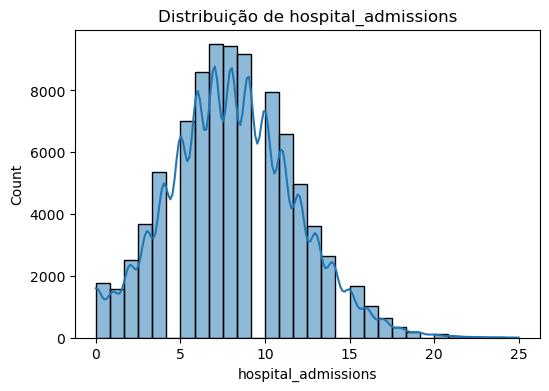

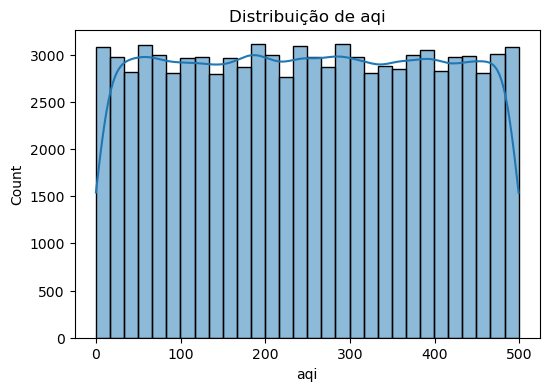

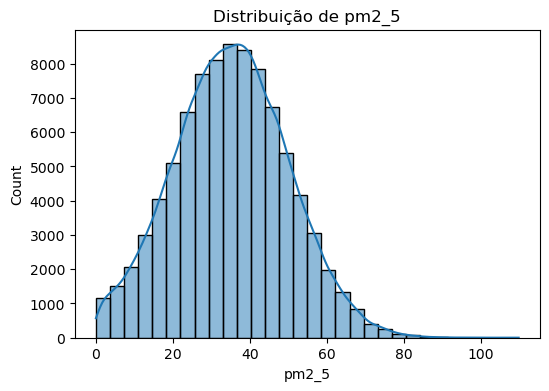

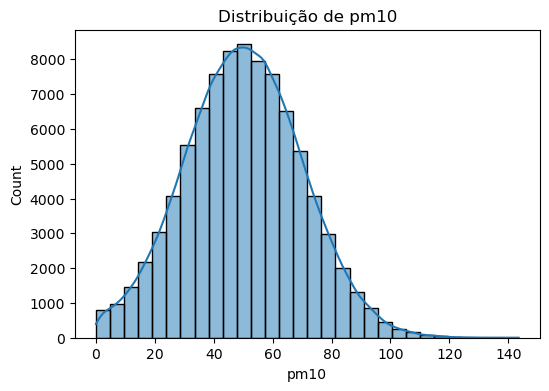

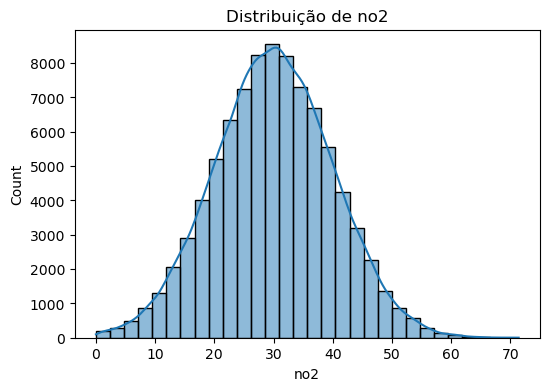

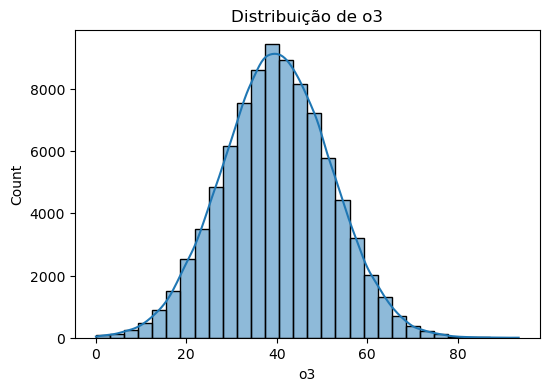

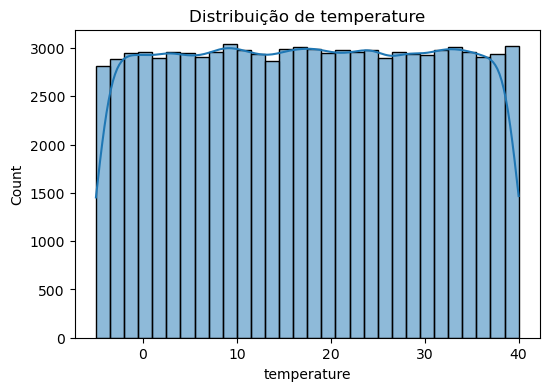

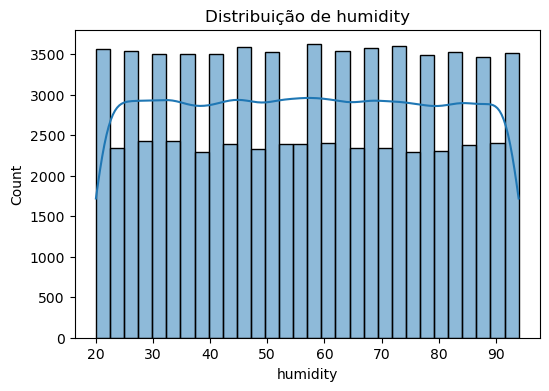

In [32]:
#Laço que passa por todas as colunas e cria um gráfico de histplot
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df_original, x=col, kde=True, bins=30)
    plt.title(f'Distribuição de {col}')
    plt.show()

Alguns dados estão bem simetricos e outros com cauda a esquerda ou a direita. Antes de tratar os outliers farei mais alguns testes para validação.

### 2.2 - Boxplots por Variável Numérica

Objetivo: Visualizar os outliers e a dispersão.

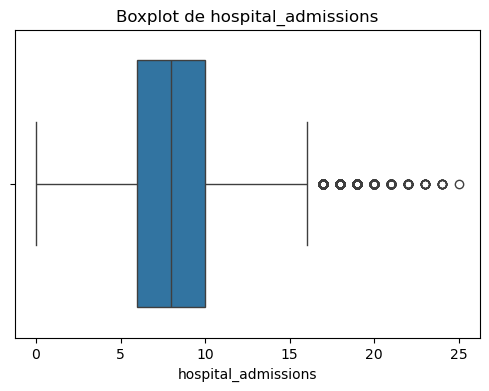

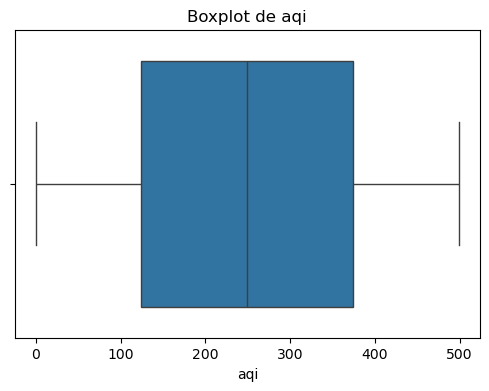

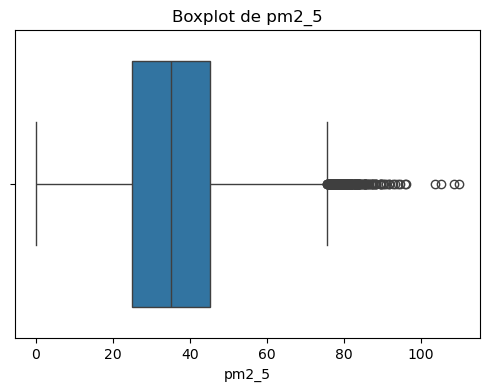

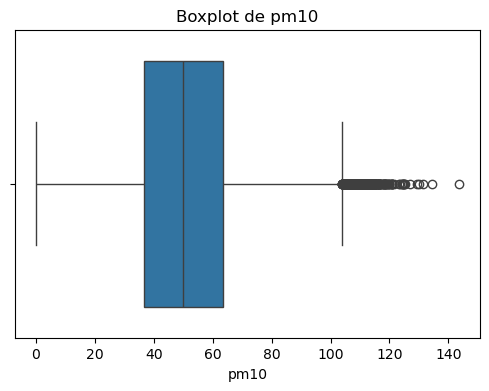

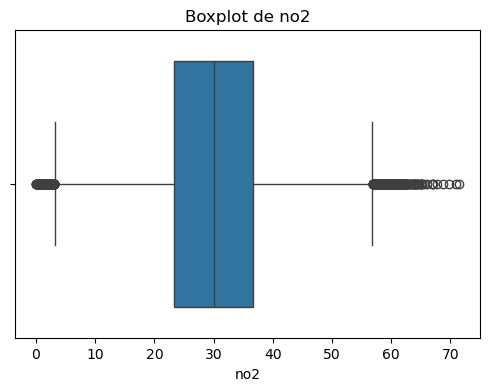

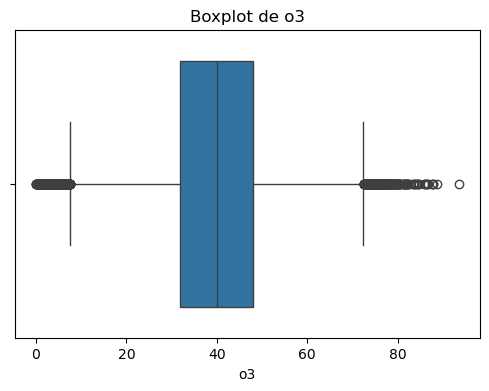

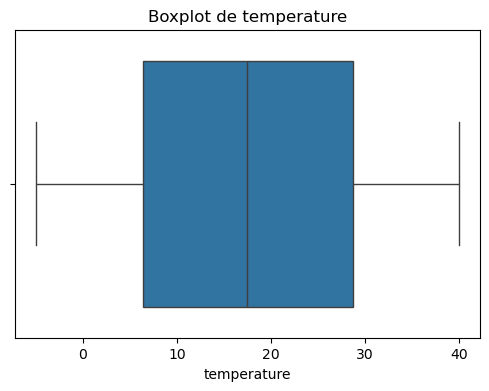

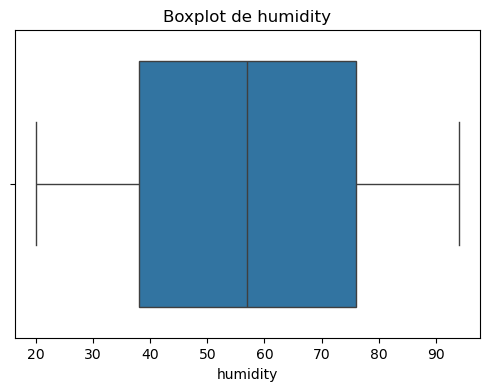

In [33]:
#Laço que passa por todas as colunas e cria um gráfico de boxplot
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=df_original, x=col)
    plt.title(f'Boxplot de {col}')
    plt.show()

### 2.3 - Correlação Entre Variáveis

Objetivo: Entender como as variáveis se relacionam entre si, principalmente com hospital_admissions.

Correlação mede a força e direção da relação linear entre duas variáveis numéricas.

O valor da correlação vai de -1 a 1:

Valor	Interpretação
- +1.0	Correlação perfeita positiva
- +0.7 a +0.9	Correlação forte positiva
- +0.4 a +0.6	Correlação moderada positiva
- +0.1 a +0.3	Correlação fraca positiva
- 0	Sem correlação
- -0.1 a -0.3	Correlação fraca negativa
- -0.4 a -0.6	Correlação moderada negativa
- -0.7 a -0.9	Correlação forte negativa
- -1.0	Correlação perfeita negativa

Importante: Correlação não implica causalidade!

O grafico de correlação não trouxe muitos insights, pois quase todas estão em 0, o chatgpt indicou utilizar o metodo "spearman", que identificaa correlações monotônicas.

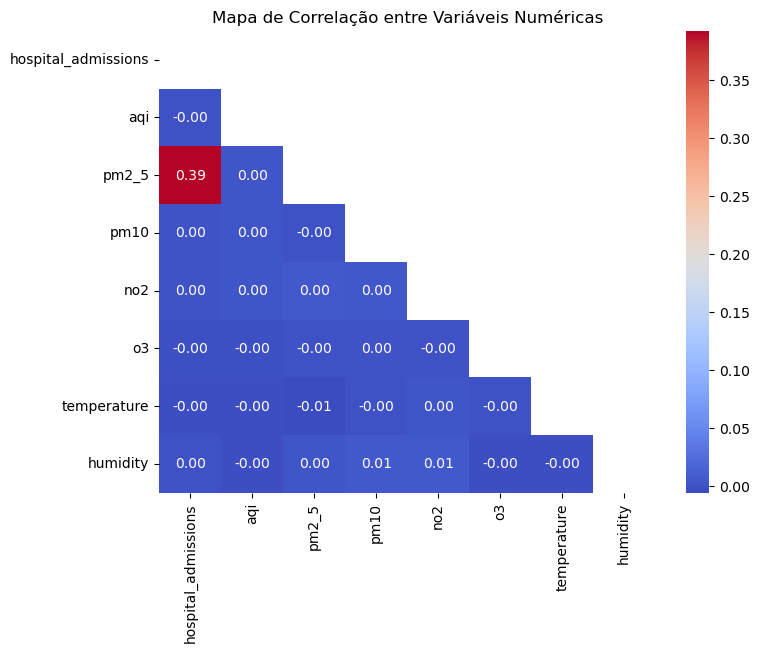

In [34]:
corr = df_original[numerical_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', mask=np.triu(corr))
plt.title('Mapa de Correlação entre Variáveis Numéricas')
plt.show()

### 2.3.1 - Correlação com metodo de Sperman



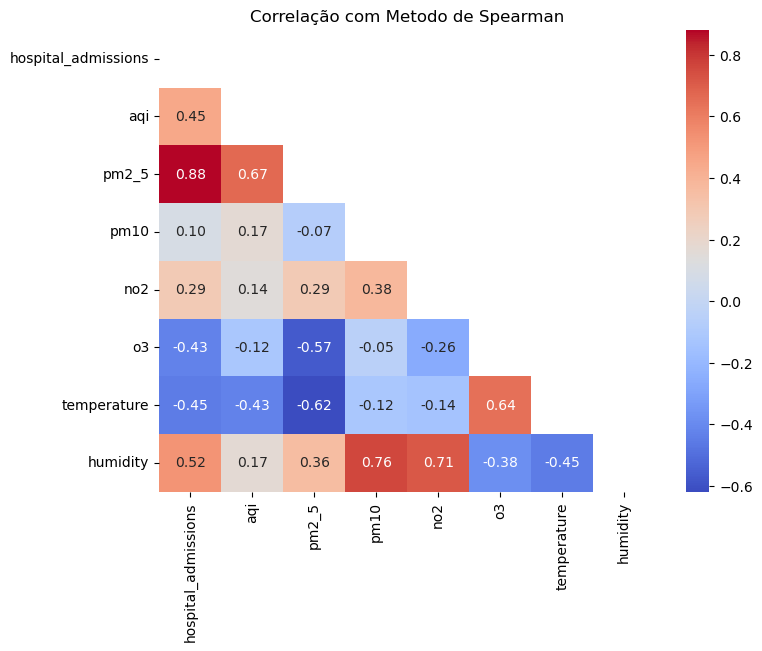

In [35]:
corr = corr.corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', mask=np.triu(corr) )
plt.title('Correlação com Metodo de Spearman')
plt.show()

| Característica                 | **Pearson** (normal) | **Spearman**                        |
| ------------------------------ | -------------------- | ----------------------------------- |
| Tipo de relação medida         | Linear               | Monótona (não precisa ser linear)   |
| Base de cálculo                | Valores reais        | Ranks (posições na ordem dos dados) |
| Sensível a outliers?           | Sim                  | Menos sensível                      |
| Exige distribuição normal?     | Sim (idealmente)     | Não                                 |
| Detecta curvaturas (tipo "U")? | Não                  | Às vezes (se monotônica)            |

Quando usar qual?

Use Pearson quando:
- Quer medir correlação linear
- Os dados são contínuos e bem distribuídos
- Não há muitos outliers

Use Spearman quando:
- A relação pode ser não linear
- Os dados são ordinais ou têm outliers
- Você quer saber se quando uma aumenta, a outra também aumenta (ou diminui), mesmo sem ser uma linha reta


### 2.4 - Tendências Temporais

Objetivo: Ver evolução das variáveis ao longo do tempo

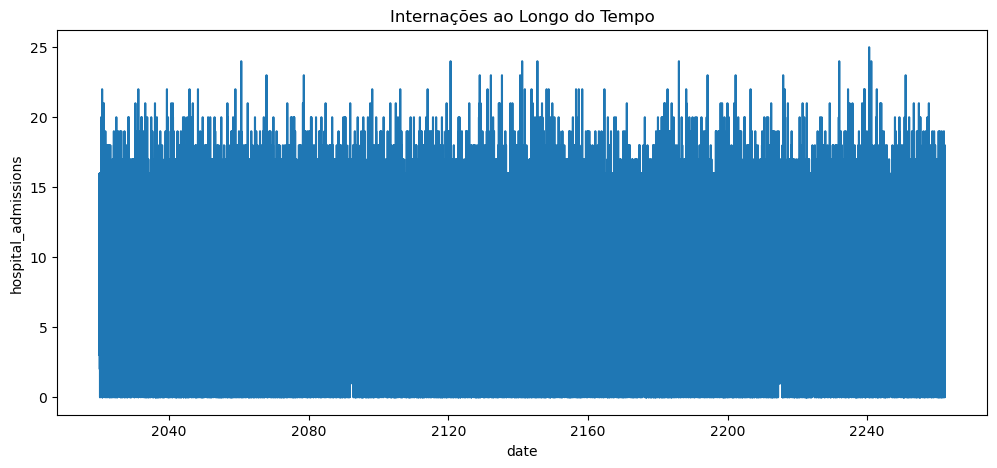

In [36]:
#Converte a coluna date, para "datetime"
df_original['date'] = pd.to_datetime(df_original['date'], format='%Y-%m-%d')  # formato yyyy/mm/dd

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_original, x='date', y='hospital_admissions')
plt.title('Internações ao Longo do Tempo')
plt.show()

In [37]:
#Tratamento para separar a coluna de Data em: Ano, Mês e Dia
df_original['ano'] = df_original['date'].dt.year
df_original['mes'] = df_original['date'].dt.month
df_original['dia'] = df_original['date'].dt.day
df_original['dia_da_semana'] = df_original['date'].dt.weekday #0 = segunda, 6 = domingo

#Drop na coluna de date
df_original = df_original.drop(columns=['date'])

#Imprime para confirmar alteações
df_original.head()

,city,aqi,pm2_5,pm10,no2,o3,temperature,humidity,hospital_admissions,population_density,hospital_capacity,ano,mes,dia,dia_da_semana
0,Los Angeles,65,34.0,52.7,2.2,38.5,33.5,33,5,Rural,1337,2020,1,1,2
1,Beijing,137,33.7,31.5,36.7,27.5,-1.6,32,4,Urban,1545,2020,1,2,3
2,London,266,43.0,59.6,30.4,57.3,36.4,25,10,Suburban,1539,2020,1,3,4
3,Mexico City,293,33.7,37.9,12.3,42.7,-1.0,67,10,Urban,552,2020,1,4,5
4,Delhi,493,50.3,34.8,31.2,35.6,33.5,72,9,Suburban,1631,2020,1,5,6


In [38]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88489 entries, 0 to 88488
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   city                 88489 non-null  object 
 1   aqi                  88489 non-null  int64  
 2   pm2_5                88489 non-null  float64
 3   pm10                 88489 non-null  float64
 4   no2                  88489 non-null  float64
 5   o3                   88489 non-null  float64
 6   temperature          88489 non-null  float64
 7   humidity             88489 non-null  int64  
 8   hospital_admissions  88489 non-null  int64  
 9   population_density   88489 non-null  object 
 10  hospital_capacity    88489 non-null  int64  
 11  ano                  88489 non-null  int32  
 12  mes                  88489 non-null  int32  
 13  dia                  88489 non-null  int32  
 14  dia_da_semana        88489 non-null  int32  
dtypes: float64(5), int32(4), int64(4), o

### 2.5 - Distribuição por Tipo de Região (population_density)

Objetivo: Comparar poluição, temperatura, ou hospitalizações entre áreas urbanas, suburbanas e rurais.

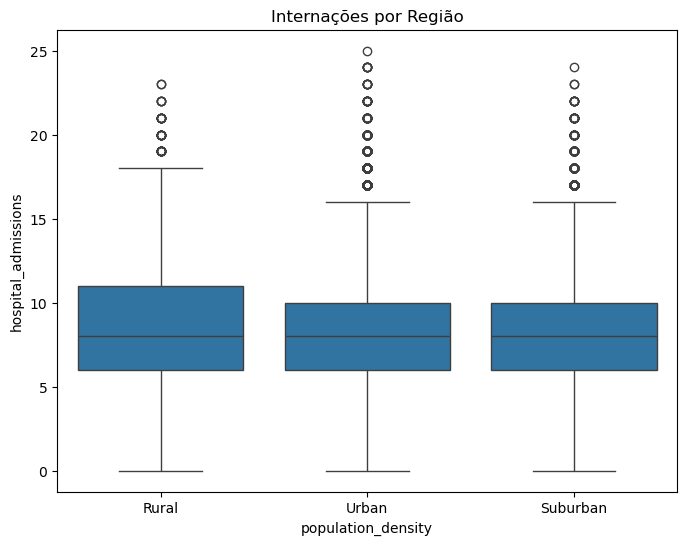

In [39]:
plt.figure(figsize=(8, 6))
sns.boxplot(df_original, x='population_density', y='hospital_admissions')
plt.title('Internações por Região')
plt.show()

---
## 3 - Pré-processamento para Modelagem

- Separar antes de tratar outliers e escalar é a abordagem correta para evitar data leakage.
- Se escalar ou tratar outliers com base em toda a base, o modelo "vê" dados de teste no pré-processamento, o que é um vazamento

In [ ]:
# 1. Selecionar apenas colunas numéricas (exceto hospital_admissions)
numerical_cols = df_original.select_dtypes(include=['float64', 'int64']).columns.drop('hospital_admissions')

X = df_original[numerical_cols]
y = df_original['hospital_admissions']

# 2. Separar as variáveis em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 3.1 - Verificar Assimetria dos Dados

Teste de para verificar assimetria dos dados numericos

Interpretação:
- p_value > 0.05 → distribuição provavelmente normal (não rejeita H0).
- p_value <= 0.05 → distribuição não normal (rejeita H0, provável assimetria).

In [55]:
# Criar um dicionário para armazenar os resultados
normality_results = {}

# Loop em todas as colunas numéricas
for col in X_train.select_dtypes(include=['float64', 'int64']).columns:
    stat, p = normaltest(X_train[col].dropna())  # Evita problemas com NaN
    normality_results[col] = {'stat': stat, 'p_value': p}

# Transformar em DataFrame para visualização fácil
normality_df = pd.DataFrame(normality_results).T
normality_df['normal'] = normality_df['p_value'] > 0.05  # True = distribuição normal
print(normality_df)

                           stat       p_value  normal
aqi                60291.279807  0.000000e+00   False
pm2_5                241.752045  3.193084e-53   False
pm10                 142.068341  1.413356e-31   False
no2                   17.399027  1.666669e-04   False
o3                     4.075342  1.303319e-01    True
temperature        60145.231511  0.000000e+00   False
humidity           60097.271710  0.000000e+00   False
hospital_capacity  59271.411617  0.000000e+00   False


### 3.1.1 - Tratar Outliers (somente no conjunto de treino)


- Q1: Primeiro quartil (25% dos dados estão abaixo desse valor).
- Q3: Terceiro quartil (75% dos dados estão abaixo desse valor).
- IQR: Intervalo interquartil = Q3 - Q1.

Este intervalo representa a “zona segura” onde normalmente se encontram os dados.

In [56]:
#Seleciona apenas colunas númericas
X_train_num = X_train.select_dtypes(include=['float64', 'int64']) #não adicionei tipo int32, para nao puxar as colunas de datas (ano, mes, dia e dia da semana)

#Calcula o IQR nos dados númericos
Q1 = X_train_num.quantile(0.25)
Q3 = X_train_num.quantile(0.75)

IQR = Q3 - Q1

#Máscara booleana para manter apenas linhas sem outliers
mask = ~((X_train_num < (Q1 - 1.5 * IQR)) | (X_train_num > (Q3 + 1.5 * IQR))).any(axis=1)

#Aplica máscara ao X_train e y_train 
X_train_no_outliers = X_train[mask]
y_train_no_outliers = y_train[mask]

In [57]:
#Confirma se o tratamento de outliers funcionou
print(f'Antes: {X_train.shape[0]} amostras')
print(f'Depois: {X_train_no_outliers.shape[0]} amostras')

Antes: 70791 amostras
Depois: 69346 amostras


#Verificar visualmente se os outliers sumiram
for col in X_train_no_outliers.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(8, 5))
    sns.histplot(X_train_no_outliers[col], kde=True)
    plt.title(f'Distribuição limpa: {col}')
    plt.grid(True)
    plt.show()

---
## 4 - Modelos de ML e Metricas de Avaliação

Mean Squared Error: 11.535911272330235
R^2 Score: 0.15936477543156558


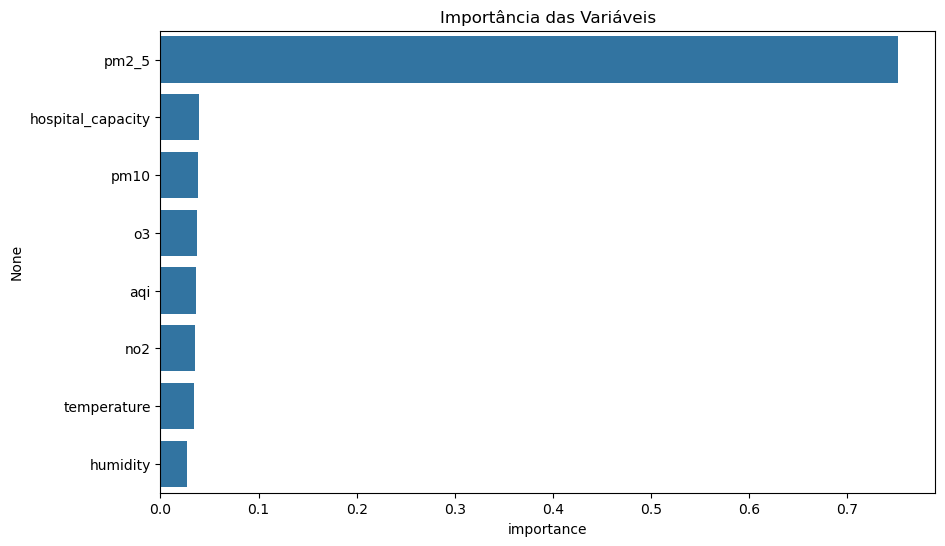

In [ ]:
#Implementa modelo de machine learning e fit
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train_no_outliers, y_train_no_outliers)

#Realiza previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

#Avalia o modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')
#Visualiza a importância das variáveis
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index=X_train_no_outliers.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances['importance'], y=feature_importances.index)
plt.title('Importância das Variáveis')
plt.show()

In [65]:
from sklearn.ensemble import GradientBoostingRegressor

# Treina o modelo Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb_model.fit(X_train_no_outliers, y_train_no_outliers)

# Faz previsões
y_pred_gb = gb_model.predict(X_test)

# Avalia o modelo
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)
print(f'Gradient Boosting - Mean Squared Error: {mse_gb}')
print(f'Gradient Boosting - R^2 Score: {r2_gb}')

Gradient Boosting - Mean Squared Error: 11.576957767302195
Gradient Boosting - R^2 Score: 0.15637366976995526


- Pearson mede apenas correlação linear. Se tudo ficou próximo de zero, significa que não há relação linear forte entre as variáveis preditoras e o target (hospital_admissions).
- Spearman mede correlação monotônica (quando uma variável aumenta, a outra tende a aumentar ou diminuir, mas não necessariamente de forma linear). Se Spearman trouxe correlações, isso indica que pode haver relações não lineares ou ordinais entre as variáveis.


O que isso diz sobre o baixo desempenho dos modelos?

- Modelos lineares (como regressão linear, Ridge, Lasso) não vão funcionar bem, pois não há relação linear.
- Modelos de árvore (Random Forest, Gradient Boosting) conseguem capturar relações não lineares, mas se mesmo assim o desempenho está ruim, provavelmente:
    - As relações monotônicas não são fortes o suficiente para explicar o target.
    - Existem outros fatores importantes para hospitalizações que não estão no seu dataset.
    - Pode haver muito ruído ou variáveis pouco informativas.

Resumo:
Seu dataset tem relações fracas ou não lineares entre as variáveis e o target. Isso limita o desempenho de qualquer modelo. O ideal é buscar mais variáveis explicativas ou tentar abordagens diferentes (ex: análise temporal, agrupamentos, variáveis derivadas)

- Analise temporal não seria viavel, pois o dataset não contem datas fidedignas, pois estão com datas futuras que foram preenchidas de forma aleatoria.

---
## Conclusão

Este exercicio foi feito para praticar tecnicas de modelagem de dados e estruturar um notebook. Seguindo alguns dos aprendizados nos cursos/ trilhas feito na Alura. A analise abaixo e mapeamento foi feita com ajuda do Copilot.


###Técnicas Utilizadas:

- Leitura e exploração inicial:
    - Carregamento do dataset com pandas.
    - Análise de tipos, valores nulos, duplicados e estatísticas descritivas.
    - Verificação de valores únicos em colunas categóricas.
- Visualização de dados:
    - Histogramas e boxplots para distribuição e outliers.
    - Heatmap de correlação (Pearson e Spearman).
    - Análise temporal de hospitalizações.
    - Boxplot por categoria (population_density).
- Pré-processamento:
    - Conversão de datas e extração de ano, mês, dia e dia da semana.
    - Separação correta de treino e teste antes do tratamento.
    - Teste de normalidade (D’Agostino) nas variáveis numéricas.
    - Tratamento de outliers apenas no conjunto de treino (IQR).
- Modelagem preditiva:
    - RandomForestRegressor e GradientBoostingRegressor.
    - Avaliação com Mean Squared Error (MSE) e R² Score.
    - Visualização da importância das variáveis.

### Acertos:

- Pipeline bem estruturado, com separação clara das etapas.
- Tratamento de outliers feito apenas no treino, evitando data leakage.
- Uso de métodos de correlação adequados (Pearson e Spearman).
- Teste de normalidade para orientar o tratamento dos dados.
- Aplicação de modelos de árvore, mais adequados para relações não lineares.
- Visualização da importância das variáveis.


### Erros e Pontos de Melhoria para uma v2:

- Feature Engineering: Pouca criação de novas variáveis derivadas; explorar interações, médias móveis, lags temporais, etc.
- Variáveis Categóricas: Não há tratamento explícito de encoding para ‘city’ e ‘population_density’ (OneHotEncoder pode ajudar).
- Escalonamento: Não foi aplicado scaler nas variáveis numéricas; pode ajudar alguns modelos.
- Validação Cruzada: Apenas train/test split; usar cross-validation para avaliação mais robusta.
- Modelos: Testar outros modelos (ex: regressão regularizada, XGBoost, redes neurais).
- Análise Temporal: Apesar das datas não serem reais, poderia tentar agrupamentos por mês/ano para suavizar ruídos.
- Explicabilidade: Faltou análise de resíduos e gráficos de previsão vs. real.
- Dados: Se possível, buscar mais variáveis externas (clima, eventos, políticas públicas) para enriquecer o modelo.
- Documentação: Adicionar mais comentários explicando decisões e interpretações dos resultados.

### Resumo:
O notebook cobre bem o fluxo de EDA e modelagem, mas o desempenho dos modelos é limitado pela baixa relação entre as variáveis e o target. Para uma v2, foque em engenharia de features, tratamento de categóricas, validação cruzada e busca de mais variáveis explicativas.